In [1]:
!pip install -q gdown

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import Caltech101

torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

# fix seed
np.random.seed(0)

## Data

In [3]:
batch_size = 256
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)


dataset = Caltech101(root="./data", download=True, transform=train_transform)

# # split dataset
n_train = int(len(dataset) * 0.8)
n_val = len(dataset) - n_train

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [4]:
for data, target in testloader:
    print(data.shape)
    print(target)
    break

torch.Size([256, 3, 224, 224])
tensor([ 66,  61,  53,  35,  12,  23,  43,  60,   3,   3,   3,  72,   1,  19,
         91,  27,  79,  29,  78,  47,  29,  33,  76,   0,  78,   1,  81,  26,
         59,   2,   5,   3,   1,  60,   3,   3,  45,  96,  54,   0,  78,  96,
          3,  39,  40,  26,   0,   5,   5,  26,  87,  32,   3,   3,  96,  21,
          0,  74,  13,   0,  38,   3,  92,   2,  12,  30,   0,  61,  57,  26,
         65,  71,  49,  47,  60,  16,  92,  12,  74,  12,   2,  13,  68,  50,
         40,  67,  19,   0,  79,  65,   2,   3,   3,  37,  98,  60,  65,   5,
         91,  11,  73,   3,  75,  66,   1,  54,  81,   3,   5,  20,   3,   5,
          3,  52,  37,   2,  59,   9,   5,  85,   5,   5,  87,  85,  50,  94,
         32,   0,  14,  15,  94,  51,  90,  22,  33,   1,  62,   0,  33,   5,
         45,  75,  59,  50,  77,   2,  36,   5,  22,  78,  58,  87,   1,  54,
          3,   3,   2,   5,  75,  94,   5,   3,  10,   0,  30,   3,  16,  69,
         55,  44, 100,  90,  97, 

## Model

In [5]:
from torchvision.models import mobilenet_v3_small


class Model(nn.Module):
    def __init__(self, num_classes=2):
        super(Model, self).__init__()
        self.backbone = mobilenet_v3_small(pretrained=True)
        self.backbone.classifier = nn.Sequential()

        self.head = nn.Linear(576, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [6]:
model = Model(num_classes=101).to(device)

/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
x = torch.randn(2, 3, 224, 224).to(device)
print(model(x).shape)

torch.Size([2, 101])


# Train

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [9]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [10]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 30

In [11]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0  # to track number of correct predictions
    total = 0  # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(
        f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%"
    )

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/ 30] 	 Loss: 4.24413     Accuracy: 18.43% 	 Test Loss: 3.74370     Test Accuracy: 25.69%
Epoch [  2/ 30] 	 Loss: 3.37101     Accuracy: 34.20% 	 Test Loss: 3.19070     Test Accuracy: 28.28%
Epoch [  3/ 30] 	 Loss: 2.98311     Accuracy: 39.46% 	 Test Loss: 2.99063     Test Accuracy: 31.97%
Epoch [  4/ 30] 	 Loss: 2.68811     Accuracy: 44.63% 	 Test Loss: 2.75733     Test Accuracy: 40.90%
Epoch [  5/ 30] 	 Loss: 2.39665     Accuracy: 52.64% 	 Test Loss: 2.51342     Test Accuracy: 50.17%
Epoch [  6/ 30] 	 Loss: 2.08034     Accuracy: 60.21% 	 Test Loss: 2.26121     Test Accuracy: 57.20%
Epoch [  7/ 30] 	 Loss: 1.80005     Accuracy: 66.42% 	 Test Loss: 2.03320     Test Accuracy: 62.33%
Epoch [  8/ 30] 	 Loss: 1.54443     Accuracy: 71.39% 	 Test Loss: 1.79882     Test Accuracy: 66.01%
Epoch [  9/ 30] 	 Loss: 1.32127     Accuracy: 75.59% 	 Test Loss: 1.58564     Test Accuracy: 69.07%
Epoch [ 10/ 30] 	 Loss: 1.14332     Accuracy: 78.63% 	 Test Loss: 1.43575     Test Accuracy: 71.31%


In [12]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(
    f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%"
)


Best epoch: 30 with test accuracy: 86.75%


# Plot results

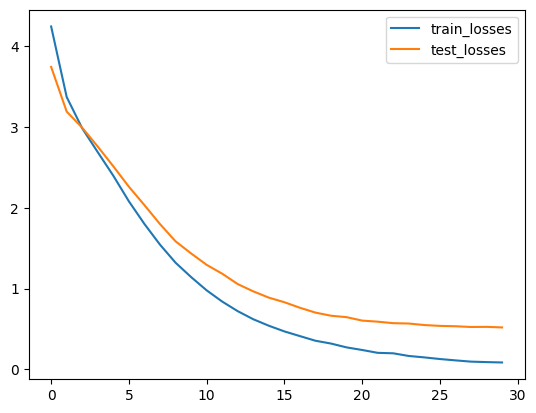

In [13]:
plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()

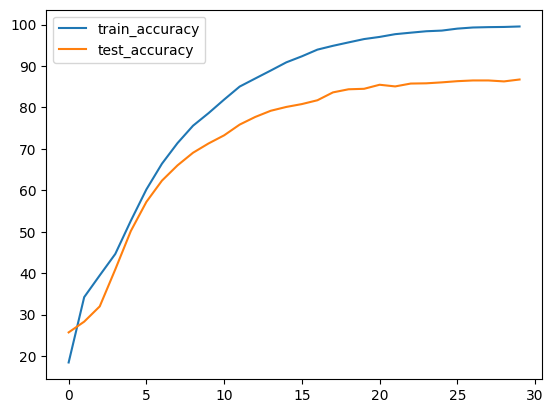

In [14]:
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(test_accuracies, label="test_accuracy")
plt.legend()